# Project 5: Wrangle and Analyze Data

## Prepared by: Lamia Alshawi

## Gather

In [8]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json

In [9]:
# gather and read WeRateDogs Twitter archive CSV
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [10]:
# downloaded the image prediction file programmatically using the Requests library and save tsv to file
url = ('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
response = requests.get(url)
with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)
# read file
image_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [11]:
# extract the file from the zipfile
with open('tweet-json.zip','rb') as f:
    tweets = zipfile.ZipFile(f)
    tweets.extractall()

In [12]:
# read the file in DataFrame
with open('tweet-json copy', 'r') as f:
    tweet_json_df = pd.read_json(f, lines= True, encoding = 'utf-8')

# select the columns of interest 'id', 'favorite_count','retweet_count'
tweet_json_df = tweet_json_df.loc[:,['id','favorite_count','retweet_count']]

## Assess

Now we assess each dataframe for quality and tidiness and describe each column variable. Assess them visually and programmatically for quality and tidiness issues.

In [13]:
twitter_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [14]:
image_predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [15]:
tweet_json_df

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774
...,...,...,...
2349,666049248165822465,111,41
2350,666044226329800704,311,147
2351,666033412701032449,128,47
2352,666029285002620928,132,48


In [16]:
# get Twitter Archive info
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
# Twitter Archive description
twitter_archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
# Twitter Archive sample
twitter_archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
677,789280767834746880,NaN,NaN,2016-10-21 01:42:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Meyer. He has to hold s...,7.507196e+17,4.196984e+09,2016-07-06 15:54:42 +0000,https://twitter.com/dog_rates/status/750719632...,12,10,Meyer,None,None,None,None
1417,698549713696649216,NaN,NaN,2016-02-13 16:50:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Claude. He's trying to be seductive bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/698549713...,9,10,Claude,None,None,None,None
1745,679148763231985668,NaN,NaN,2015-12-22 03:57:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I know everyone's excited for Christmas but th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679148763...,8,10,None,None,None,None,None
718,783466772167098368,NaN,NaN,2016-10-05 00:40:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Finn. He likes eavesdropping from fili...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/783466772...,11,10,Finn,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [19]:
# image predictions info
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
# image predictions description
image_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [21]:
# image predictions sample
image_predictions_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
23,666345417576210432,https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg,1,golden_retriever,0.858744,True,Chesapeake_Bay_retriever,0.054787,True,Labrador_retriever,0.014241,True
68,667182792070062081,https://pbs.twimg.com/media/CUJPNjOWsAAZRqP.jpg,1,golden_retriever,0.949892,True,Irish_setter,0.010564,True,Chesapeake_Bay_retriever,0.005821,True
434,674372068062928900,https://pbs.twimg.com/media/CVvZ0KTWwAAdXKV.jpg,1,seashore,0.346126,False,American_alligator,0.106404,False,sandbar,0.049349,False
442,674632714662858753,https://pbs.twimg.com/media/CVzG3yOVAAAqi9I.jpg,1,jellyfish,0.432748,False,goldfish,0.113111,False,coral_reef,0.087047,False
525,676606785097199616,https://pbs.twimg.com/media/CWPKSGpWcAQN6mw.jpg,1,Loafer,0.202999,False,doormat,0.200411,False,malinois,0.142300,True


In [22]:
# tweet_json data info
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   favorite_count  2354 non-null   int64
 2   retweet_count   2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [23]:
# tweet_json data description
tweet_json_df.describe()

,id,favorite_count,retweet_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


In [24]:
# tweet_json data sample
tweet_json_df.sample(5)

,id,favorite_count,retweet_count
1035,744709971296780288,6150,1771
1812,676617503762681856,3149,1108
1761,678446151570427904,4358,1785
1919,674262580978937856,1391,498
1826,676263575653122048,2243,609


Quality

- Remove data contains retweets because we are only interested in original tweets
- Change tweet_id to a string/object instead of integer
- drop unnecessary columns that are not needed for analysis
- in the name column there are values that are inacuartely named like "a", "an", "all"
- the name column also has none instead of NaN 
- timestamp is an object we need to change it into datetime
- Some tweets have the same jpg_url
- some tweets have no image
- not need the tweets beyond August 1st, 2017.

Tidiness
- Merge all data frames by tweet_id.
- Combine dog stages doggo, puppo, pupper, floofer into one column 'dog_stage'

## Clean

In [25]:
tweet_json_clean = tweet_json_df.copy()
twitter_archive_clean = twitter_archive_df.copy()
image_predictions_clean= image_predictions_df.copy()

### Tidiness

##### Define

Merge all data frames by tweet_id.

##### Code

In [26]:
twitter_archive_clean = pd.merge(left=twitter_archive_clean, right=tweet_json_clean, left_on='tweet_id', right_on='id', how='inner')

In [27]:
twitter_df = twitter_archive_clean.merge(image_predictions_clean, on='tweet_id', how='inner')

##### Test

In [28]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  doggo                       2073 

#### Define

Combine dog stage columns (doggo, floofer, pupper, puppo) into one 'dog_stage'

#### Code

In [29]:
# Extract dog stages from 'text' column into new 'dog_stage' column 
twitter_df['dog_stage'] = twitter_df['text'].str.extract('(doggo|floofer|pupper|puppo)')

In [30]:
twitter_df[['dog_stage','doggo', 'floofer', 'pupper', 'puppo']].head(15)

,dog_stage,doggo,floofer,pupper,puppo
0,NaN,None,None,None,None
1,NaN,None,None,None,None
2,NaN,None,None,None,None
3,NaN,None,None,None,None
4,NaN,None,None,None,None
5,NaN,None,None,None,None
6,NaN,None,None,None,None
7,NaN,None,None,None,None
8,NaN,None,None,None,None
9,doggo,doggo,None,None,None


In [31]:
# now drop doggo, floofer, pupper, and puppo columns
twitter_df = twitter_df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

#### Test

In [32]:
twitter_df.dog_stage.value_counts()

pupper     230
doggo       75
puppo       29
floofer      3
Name: dog_stage, dtype: int64

### Quality

#### Define

Remove data contains retweets because we are only interested in original tweets

#### Code

In [33]:
twitter_df = twitter_df.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

#### Test

In [34]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2073 non-null   int64  
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              2073 non-null   object 
 4   source                 2073 non-null   object 
 5   text                   2073 non-null   object 
 6   expanded_urls          2073 non-null   object 
 7   rating_numerator       2073 non-null   int64  
 8   rating_denominator     2073 non-null   int64  
 9   name                   2073 non-null   object 
 10  id                     2073 non-null   int64  
 11  favorite_count         2073 non-null   int64  
 12  retweet_count          2073 non-null   int64  
 13  jpg_url                2073 non-null   object 
 14  img_num                2073 non-null   int64  
 15  p1  

#### Define

Change tweet_id to a string/object instead of integer

#### Code

In [35]:
twitter_df['tweet_id'] = twitter_df['tweet_id'].astype(str)

#### Test

In [36]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2073 non-null   object 
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              2073 non-null   object 
 4   source                 2073 non-null   object 
 5   text                   2073 non-null   object 
 6   expanded_urls          2073 non-null   object 
 7   rating_numerator       2073 non-null   int64  
 8   rating_denominator     2073 non-null   int64  
 9   name                   2073 non-null   object 
 10  id                     2073 non-null   int64  
 11  favorite_count         2073 non-null   int64  
 12  retweet_count          2073 non-null   int64  
 13  jpg_url                2073 non-null   object 
 14  img_num                2073 non-null   int64  
 15  p1  

#### Define

drop unnecessary columns that are not needed for analysis

#### Code

In [37]:
twitter_df = twitter_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'img_num',  'source'], axis=1)

#### Test

In [38]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2073 non-null   object 
 1   timestamp           2073 non-null   object 
 2   text                2073 non-null   object 
 3   expanded_urls       2073 non-null   object 
 4   rating_numerator    2073 non-null   int64  
 5   rating_denominator  2073 non-null   int64  
 6   name                2073 non-null   object 
 7   id                  2073 non-null   int64  
 8   favorite_count      2073 non-null   int64  
 9   retweet_count       2073 non-null   int64  
 10  jpg_url             2073 non-null   object 
 11  p1                  2073 non-null   object 
 12  p1_conf             2073 non-null   float64
 13  p1_dog              2073 non-null   bool   
 14  p2                  2073 non-null   object 
 15  p2_conf             2073 non-null   float64
 16  p2_dog

#### Define

- name column there are values that are inacuartely named like "a", "an", "all"
- the name column also has none instead of NaN 

#### Code

In [39]:
# Find all names are only lowercase letters
lowercase = []
for row in twitter_df['name']:
    if row[0].islower() and row not in lowercase:
        lowercase.append(row)
print(lowercase)

['such', 'a', 'quite', 'one', 'incredibly', 'an', 'very', 'just', 'my', 'not', 'his', 'getting', 'this', 'unacceptable', 'all', 'infuriating', 'the', 'actually', 'by', 'officially', 'light', 'space']


In [40]:
# replace lowercase letters with a NaN
twitter_df['name'].replace(lowercase, np.nan, inplace = True)

In [41]:
# replace None with a NaN
twitter_df['name'].replace('None', np.nan, inplace = True)

#### Test

In [42]:
twitter_df['name'].value_counts()

Charlie    11
Cooper     10
Oliver     10
Tucker     10
Penny      10
           ..
Bilbo       1
Erik        1
Peanut      1
Donny       1
Huxley      1
Name: name, Length: 913, dtype: int64

#### Define

timestamp is an object we need to change it into datetime

#### Code

In [43]:
twitter_df['timestamp'] = pd.to_datetime(twitter_df.timestamp)

#### Test

In [44]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2073 non-null   object             
 1   timestamp           2073 non-null   datetime64[ns, UTC]
 2   text                2073 non-null   object             
 3   expanded_urls       2073 non-null   object             
 4   rating_numerator    2073 non-null   int64              
 5   rating_denominator  2073 non-null   int64              
 6   name                1396 non-null   object             
 7   id                  2073 non-null   int64              
 8   favorite_count      2073 non-null   int64              
 9   retweet_count       2073 non-null   int64              
 10  jpg_url             2073 non-null   object             
 11  p1                  2073 non-null   object             
 12  p1_conf             2073 non-null 

#### Define

Some tweets have the same jpg_url

#### Code

In [45]:
# how many duplicated images 
sum(twitter_df.jpg_url.duplicated())

65

In [46]:
# drop duplicated images
twitter_df = twitter_df.drop_duplicates(subset=['jpg_url'], keep='last')

In [47]:
# drop tweets with no images
twitter_df = twitter_df.dropna(subset = ['jpg_url'])

#### Test

In [48]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2072
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2008 non-null   object             
 1   timestamp           2008 non-null   datetime64[ns, UTC]
 2   text                2008 non-null   object             
 3   expanded_urls       2008 non-null   object             
 4   rating_numerator    2008 non-null   int64              
 5   rating_denominator  2008 non-null   int64              
 6   name                1350 non-null   object             
 7   id                  2008 non-null   int64              
 8   favorite_count      2008 non-null   int64              
 9   retweet_count       2008 non-null   int64              
 10  jpg_url             2008 non-null   object             
 11  p1                  2008 non-null   object             
 12  p1_conf             2008 non-null 

#### Define

we do not need the tweets beyond August 1st, 2017.

#### Code

In [49]:
tweets_august = '2017-08-01 00:00:00'
twitter_df = twitter_df[(twitter_df['timestamp'] < tweets_august)]

#### Test

In [50]:
(twitter_df['timestamp'] > tweets_august).value_counts()

False    2006
Name: timestamp, dtype: int64

## Storing, Analyzing, and Visualizing Data

In [51]:
twitter_df.to_csv('twitter_archive_master.csv', index = False)

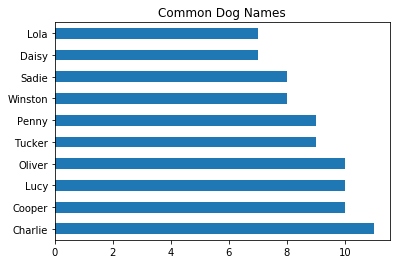

In [52]:
dognames = twitter_df['name'].value_counts().head(10)
dognames.plot(kind='barh', title = 'Common Dog Names');

Text(0, 0.5, 'Favorites')

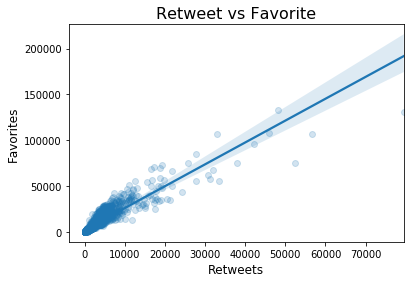

In [53]:
sns.regplot(x="retweet_count", y="favorite_count", data=twitter_df, scatter_kws={'alpha':0.2})
plt.title('Retweet vs Favorite', size=16)
plt.xlabel('Retweets', size=12)
plt.ylabel('Favorites', size=12)

Text(0.5, 1.0, 'Most Predicted Dog Breeds')

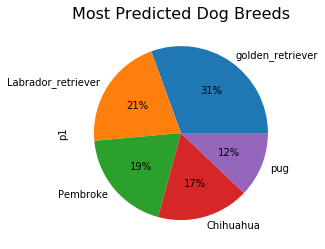

In [54]:
dogbreeds = twitter_df.p1.value_counts()[0:5]
dogbreeds.plot(kind = 'pie', autopct='%1.0f%%')
plt.title('Most Predicted Dog Breeds', size=16)

Text(0.5, 1.0, 'Most Common Dog Stages')

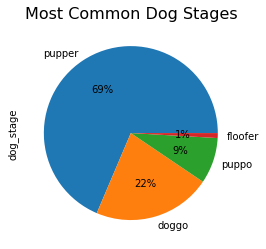

In [55]:
dogstage = twitter_df.dog_stage.value_counts()
dogstage.plot(kind = 'pie', autopct='%1.0f%%')
plt.title('Most Common Dog Stages', size=16)